<a href="https://colab.research.google.com/github/adiazoq/Proyecto-Machine-Learning/blob/main/C%C3%B3digos/MODELO_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================================================
# PASO 1: INSTALAR E IMPORTAR BIBLIOTECAS NECESARIAS
# =============================================================================

# Primero necesitamos instalar neuralforecast si no está instalado
#!pip install neuralforecast pykan  # Si estás en Google Colab, descomenta esta línea

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importar KAN y otras utilidades de neuralforecast
try:
    from neuralforecast import NeuralForecast
    from neuralforecast.models import KAN, MLP
    from neuralforecast.losses.pytorch import MAE
    print("neuralforecast instalado correctamente")
except ImportError as e:
    print(f"Error importando neuralforecast: {e}")
    print("Por favor ejecuta: pip install neuralforecast pykan")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.2/263.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1
neuralforecast instalado correctamente


In [ ]:
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Bibliotecas importadas correctamente")

Bibliotecas importadas correctamente


In [ ]:
# Leer base de datos de excel
from google.colab import files
uploaded = files.upload()
!ls

Saving df_diario_promediado.xlsx to df_diario_promediado.xlsx
df_diario_promediado.xlsx  sample_data


In [ ]:
# =============================================================================
# CARGAR E IMPORTAR BASE DE DATOS
# =============================================================================

# Cargar el archivo Excel
df_diario_promediado = pd.read_excel('df_diario_promediado.xlsx')

In [ ]:
# =============================================================================
# PASO 2: PREPARAR LOS DATOS EN EL FORMATO REQUERIDO POR NEURALFORECAST
# =============================================================================

print("=" * 70)
print("PREPARANDO DATOS PARA KAN (FORMATO NEURALFORECAST)")
print("=" * 70)

"""
NeuralForecast requiere un DataFrame con 3 columnas:
1. unique_id: Identificador único de la serie (en nuestro caso, solo una serie)
2. ds: Fecha (datetime)
3. y: Valor a predecir (temperatura)
"""

# Asegurarnos de que tenemos la columna de fecha en formato datetime
df_diario_promediado['ds'] = pd.to_datetime(df_diario_promediado['Dia'])

# Crear el DataFrame en el formato requerido
Y_df = pd.DataFrame({
    'unique_id': 'temperatura_valledupar',  # Mismo ID para toda la serie
    'ds': df_diario_promediado['ds'],
    'y': df_diario_promediado['TemperaturaPromedio']
})

print(f"DataFrame preparado: {Y_df.shape}")
print(f"Columnas: {Y_df.columns.tolist()}")
print(f"Rango de fechas: {Y_df['ds'].min()} a {Y_df['ds'].max()}")
print(f"Valores únicos de ID: {Y_df['unique_id'].unique()}")

PREPARANDO DATOS PARA KAN (FORMATO NEURALFORECAST)
DataFrame preparado: (6747, 3)
Columnas: ['unique_id', 'ds', 'y']
Rango de fechas: 2006-01-01 00:00:00 a 2024-12-31 00:00:00
Valores únicos de ID: ['temperatura_valledupar']


In [ ]:
# =============================================================================
# PASO 3: SEPARAR DATOS DE ENTRENAMIENTO Y PRUEBA (2006-2020 vs 2021-2024)
# =============================================================================

print("\n" + "=" * 70)
print("SEPARANDO DATOS DE ENTRENAMIENTO Y PRUEBA")
print("=" * 70)

# Cortes EXACTOS por fecha para igualarse con ARMA y GRU
fecha_corte = "2021-01-01"

# Datos de prueba: desde 2021-01-01 hacia adelante
test_df = Y_df[Y_df['ds'] >= fecha_corte].copy()

# Datos de entrenamiento: hasta 2020-12-31
train_df = Y_df[Y_df['ds'] < fecha_corte].copy()

# Ajustar horizon según la cantidad REAL de días a predecir
horizon = len(test_df)

print(f"Datos de entrenamiento (2006-2020):")
print(f"  - Registros: {len(train_df):,}")
print(f"  - Fechas: {train_df['ds'].min()} a {train_df['ds'].max()}")
print(f"  - Duración: {(train_df['ds'].max() - train_df['ds'].min()).days} días")

print(f"\nDatos de prueba (2021-2024):")
print(f"  - Registros: {len(test_df):,}")
print(f"  - Fechas: {test_df['ds'].min()} a {test_df['ds'].max()}")
print(f"  - Duración: {(test_df['ds'].max() - test_df['ds'].min()).days} días")

print(f"\nHorizonte de predicción: {horizon} días")



SEPARANDO DATOS DE ENTRENAMIENTO Y PRUEBA
Datos de entrenamiento (2006-2020):
  - Registros: 5,421
  - Fechas: 2006-01-01 00:00:00 a 2020-12-31 00:00:00
  - Duración: 5478 días

Datos de prueba (2021-2024):
  - Registros: 1,326
  - Fechas: 2021-01-01 00:00:00 a 2024-12-31 00:00:00
  - Duración: 1460 días

Horizonte de predicción: 1326 días


In [ ]:
# =============================================================================
# PASO 4: DEFINIR LOS PARÁMETROS DEL MODELO KAN
# =============================================================================

print("\n" + "=" * 70)
print("CONFIGURANDO PARÁMETROS DEL MODELO KAN")
print("=" * 70)

"""
Explicación de parámetros importantes de KAN:
- input_size: Número de pasos históricos que el modelo mira hacia atrás
- h: Horizonte de predicción (cuántos pasos hacia adelante predecir)
- scaler_type: Tipo de normalización de datos ('standard', 'robust', 'minmax')
- max_steps: Máximo número de pasos de entrenamiento
- early_stop_patience_steps: Paciencia para early stopping
- learning_rate: Tasa de aprendizaje
- loss: Función de pérdida (MAE, MSE, etc.)
"""

# Calcular input_size (usualmente 2-3 veces el horizonte)
#input_size = 2 * horizon  # Mirar hacia atrás el doble del horizonte

# Calcular input_size (ventana histórica que usa el modelo)
# NOTA: Si es demasiado grande, KAN no puede generar todas las predicciones.
#
input_size = 2 * horizon


print(f"Parámetros del modelo KAN:")
print(f"  - input_size: {input_size} (pasos históricos)")
print(f"  - h (horizon): {horizon} (días a predecir)")
print(f"  - Frecuencia: 'D' (diaria)")

# Definir el modelo KAN
kan_model = KAN(
    h=horizon,                      # Horizonte de predicción
    input_size=input_size,          # Ventana de historia
    scaler_type='robust',           # Escalador robusto a outliers
    max_steps=1000,                 # Máximo de pasos de entrenamiento
    early_stop_patience_steps=10,   # Paciencia para early stopping
    learning_rate=0.001,            # Tasa de aprendizaje
    loss=MAE(),                     # Función de pérdida (Error Absoluto Medio)
    val_check_steps=50,             # Cada cuántos pasos validar
    random_seed=42                  # Semilla para reproducibilidad
)

print("Modelo KAN configurado")
print("Arquitectura: Red Neuronal Kolmogorov-Arnold")
print("Característica: Aprende funciones de base en lugar de pesos fijos")

INFO:lightning_fabric.utilities.seed:Seed set to 42



CONFIGURANDO PARÁMETROS DEL MODELO KAN
Parámetros del modelo KAN:
  - input_size: 2652 (pasos históricos)
  - h (horizon): 1326 (días a predecir)
  - Frecuencia: 'D' (diaria)
Modelo KAN configurado
Arquitectura: Red Neuronal Kolmogorov-Arnold
Característica: Aprende funciones de base en lugar de pesos fijos


In [ ]:
# =============================================================================
# PASO 5: CONFIGURAR EL ENTORNO DE PREDICCIÓN Y ENTRENAR EL MODELO
# =============================================================================

print("\n" + "=" * 70)
print("ENTRENANDO MODELO KAN")
print("=" * 70)

"""
NeuralForecast maneja automáticamente:
- División de datos de entrenamiento/validación
- Normalización de características
- Entrenamiento con early stopping
- Generación de predicciones
"""

# Configurar tamaño de validación (últimos datos del entrenamiento para validar)
val_size = horizon    # NeuralForecast: usar todo el train para entrenar

print(f"Configurando validación con val_size = {val_size} días")

# Crear el objeto NeuralForecast con el modelo KAN
nf = NeuralForecast(
    models=[kan_model],  # Lista de modelos (podemos agregar más para comparar)
    freq='D'             # Frecuencia diaria ('D' = Daily)
)

print("Iniciando entrenamiento del modelo KAN...")
print("Esto puede tomar varios minutos dependiendo de la complejidad...")

# Entrenar el modelo
nf.fit(
    df=train_df,          # Datos de entrenamiento
    val_size=val_size,    # Tamaño del conjunto de validación
    verbose=True          # Mostrar progreso
)

print("Entrenamiento completado")
print("El modelo KAN ha aprendido los patrones temporales de 2006-2020")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



ENTRENANDO MODELO KAN
Configurando validación con val_size = 1326 días
Iniciando entrenamiento del modelo KAN...
Esto puede tomar varios minutos dependiendo de la complejidad...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ layers       │ ModuleList    │ 20.4 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 20.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.4 M                                                                                               
Total estimated model params size (MB): 81                                                                         
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Entrenamiento completado
El modelo KAN ha aprendido los patrones temporales de 2006-2020


In [ ]:
# =============================================================================
# PASO 6: GENERAR PREDICCIONES PARA EL PERÍODO 2021-2024
# =============================================================================

print("\n" + "=" * 70)
print("GENERANDO PREDICCIONES PARA 2021-2024")
print("=" * 70)

# Generar predicciones
print("Generando predicciones para el horizonte completo...")
predictions = nf.predict()

# Resetear índice para facilitar el manejo
predictions = predictions.reset_index()

print(f"Predicciones generadas: {predictions.shape}")
print(f"Columnas en predicciones: {predictions.columns.tolist()}")

# Mostrar primeras predicciones
print("\nPrimeras 10 predicciones:")
print(predictions.head(10))

# Unir predicciones con datos reales de prueba
test_with_predictions = pd.merge(
    test_df,        # Izquierda: datos reales 2021-2024
    predictions,    # Derecha: predicciones KAN
    how='left',     # Mantener todos los reales
    on=['ds', 'unique_id']  # Cruza por fecha y ID
)

print(f"\nDatos de prueba con predicciones: {test_with_predictions.shape}")

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.



GENERANDO PREDICCIONES PARA 2021-2024
Generando predicciones para el horizonte completo...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Predicciones generadas: (1326, 4)
Columnas en predicciones: ['index', 'unique_id', 'ds', 'KAN']

Primeras 10 predicciones:
   index               unique_id         ds        KAN
0      0  temperatura_valledupar 2021-01-01  31.001856
1      1  temperatura_valledupar 2021-01-02  30.643866
2      2  temperatura_valledupar 2021-01-03  32.409904
3      3  temperatura_valledupar 2021-01-04  33.001102
4      4  temperatura_valledupar 2021-01-05  32.175739
5      5  temperatura_valledupar 2021-01-06  31.319689
6      6  temperatura_valledupar 2021-01-07  31.343317
7      7  temperatura_valledupar 2021-01-08  31.941628
8      8  temperatura_valledupar 2021-01-09  30.855066
9      9  temperatura_valledupar 2021-01-10  30.278425

Datos de prueba con predicciones: (1326, 5)


In [ ]:
#VER PRIMERAS 10 PREDICCIONES
print(test_with_predictions.head(10))
#VER ULTIMAS 10 PREDICCIONES
print(test_with_predictions.tail(10))

                unique_id         ds          y  index        KAN
0  temperatura_valledupar 2021-01-01  28.360870    0.0  31.001856
1  temperatura_valledupar 2021-01-02  28.600000    1.0  30.643866
2  temperatura_valledupar 2021-01-03  27.482609    2.0  32.409904
3  temperatura_valledupar 2021-01-04  23.454545    3.0  33.001102
4  temperatura_valledupar 2021-01-09  27.941667    8.0  30.855066
5  temperatura_valledupar 2021-01-10  28.568182    9.0  30.278425
6  temperatura_valledupar 2021-01-11  29.613636   10.0  30.770634
7  temperatura_valledupar 2021-01-12  28.191304   11.0  32.681053
8  temperatura_valledupar 2021-01-13  29.682353   12.0  31.694731
9  temperatura_valledupar 2021-01-14  28.344444   13.0  32.302013
                   unique_id         ds          y  index  KAN
1316  temperatura_valledupar 2024-12-22  27.485215    NaN  NaN
1317  temperatura_valledupar 2024-12-23  27.325172    NaN  NaN
1318  temperatura_valledupar 2024-12-24  29.049488    NaN  NaN
1319  temperatura_vall

In [ ]:
test_with_predictions

,unique_id,ds,y,index,KAN
0,temperatura_valledupar,2021-01-01,28.360870,0.0,31.001856
1,temperatura_valledupar,2021-01-02,28.600000,1.0,30.643866
2,temperatura_valledupar,2021-01-03,27.482609,2.0,32.409904
3,temperatura_valledupar,2021-01-04,23.454545,3.0,33.001102
4,temperatura_valledupar,2021-01-09,27.941667,8.0,30.855066
...,...,...,...,...,...
1321,temperatura_valledupar,2024-12-27,28.049936,NaN,NaN
1322,temperatura_valledupar,2024-12-28,27.626309,NaN,NaN
1323,temperatura_valledupar,2024-12-29,27.823402,NaN,NaN
1324,temperatura_valledupar,2024-12-30,27.484852,NaN,NaN


In [ ]:
# =============================================================================
# PASO 7 CORREGIDO: EVALUAR EL DESEMPEÑO DEL MODELO KAN
# =============================================================================

print("\n" + "=" * 70)
print("EVALUANDO DESEMPEÑO DEL MODELO KAN")
print("=" * 70)

# Primero, verificar qué está pasando con las fechas
print("Verificando alineación de fechas...")
print(f"Fechas mínimas en predicciones: {predictions['ds'].min()}")
print(f"Fechas máximas en predicciones: {predictions['ds'].max()}")
print(f"Fechas mínimas en test_df: {test_df['ds'].min()}")
print(f"Fechas máximas en test_df: {test_df['ds'].max()}")


# Esto es porque KAN predice desde el final del conjunto de entrenamiento

# SOLUCIÓN: Filtrar las predicciones para que empiecen donde empieza test_df
predictions_2021_2024 = predictions[predictions['ds'] >= '2021-01-01']

print(f"\nPredicciones filtradas para 2021-2024: {len(predictions_2021_2024)} días")
print(f"Rango: {predictions_2021_2024['ds'].min()} a {predictions_2021_2024['ds'].max()}")

# Volver a unir solo con las fechas correctas
test_with_predictions = pd.merge(
    test_df,
    predictions_2021_2024,
    how='inner',  # Solo fechas que existen en ambos
    on=['ds', 'unique_id']
)

print(f"\nDatos alineados correctamente: {test_with_predictions.shape}")
print(f"Fechas coincidentes: {test_with_predictions['ds'].min()} a {test_with_predictions['ds'].max()}")

# Calcular métricas de error
def calculate_metrics(y_true, y_pred, model_name="KAN"):
    """Calcula métricas de error para las predicciones"""

    # Convertir a arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Verificar que no haya NaN
    if np.any(np.isnan(y_true)) or np.any(np.isnan(y_pred)):
        print("Advertencia: Se encontraron valores NaN")
        print(f"  NaN en y_true: {np.isnan(y_true).sum()}")
        print(f"  NaN en y_pred: {np.isnan(y_pred).sum()}")

        # Eliminar NaN
        mask = ~(np.isnan(y_true) | np.isnan(y_pred))
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        print(f"  Datos después de eliminar NaN: {len(y_true)}")

    # Calcular métricas
    mae_val = mean_absolute_error(y_true, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))

    # Evitar división por cero en MAPE
    if np.any(y_true == 0):
        print("Advertencia: Valores cero en y_true, calculando MAPE modificado")
        # Usar un pequeño epsilon para evitar división por cero
        epsilon = 1e-10
        mape_val = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    else:
        mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Error porcentual absoluto simétrico (sMAPE)
    denominator = np.abs(y_true) + np.abs(y_pred)
    if np.any(denominator == 0):
        print("Advertencia: Denominador cero en sMAPE, usando versión modificada")
        # Añadir pequeño epsilon al denominador
        epsilon = 1e-10
        smape_val = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))
    else:
        smape_val = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    return {
        'Modelo': model_name,
        'MAE': mae_val,
        'RMSE': rmse_val,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'n_muestras': len(y_true)
    }

# Extraer valores reales y predichos
y_true = test_with_predictions['y'].values
y_pred = test_with_predictions['KAN'].values

print(f"\nDatos para evaluación:")
print(f"  Valores reales: {len(y_true)}")
print(f"  Valores predichos: {len(y_pred)}")

# Verificar tipos de datos
print(f"\nTipos de datos:")
print(f"  y_true dtype: {y_true.dtype}, contiene NaN: {np.any(np.isnan(y_true))}")
print(f"  y_pred dtype: {y_pred.dtype}, contiene NaN: {np.any(np.isnan(y_pred))}")

# Mostrar primeros valores para diagnóstico
print(f"\nPrimeros 5 valores para verificación:")
for i in range(min(5, len(y_true))):
    print(f"  [{i}] Real: {y_true[i]:.2f}, Predicho: {y_pred[i]:.2f}, Diferencia: {y_true[i]-y_pred[i]:.2f}")

# Calcular métricas
metrics = calculate_metrics(y_true, y_pred, "KAN")

print("\n" + "=" * 50)
print("MÉTRICAS DE ERROR PARA KAN (2021-2024)")
print("=" * 50)
print(f"Muestras evaluadas: {metrics['n_muestras']:,}")
print(f"Error Absoluto Medio (MAE):     {metrics['MAE']:.2f}°C")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metrics['RMSE']:.2f}°C")
print(f"Error Porcentual Absoluto Medio (MAPE): {metrics['MAPE']:.2f}%")
print(f"Error Porcentual Absoluto Simétrico (sMAPE): {metrics['sMAPE']:.2f}%")


EVALUANDO DESEMPEÑO DEL MODELO KAN
Verificando alineación de fechas...
Fechas mínimas en predicciones: 2021-01-01 00:00:00
Fechas máximas en predicciones: 2024-08-18 00:00:00
Fechas mínimas en test_df: 2021-01-01 00:00:00
Fechas máximas en test_df: 2024-12-31 00:00:00

Predicciones filtradas para 2021-2024: 1326 días
Rango: 2021-01-01 00:00:00 a 2024-08-18 00:00:00

Datos alineados correctamente: (1192, 5)
Fechas coincidentes: 2021-01-01 00:00:00 a 2024-08-18 00:00:00

Datos para evaluación:
  Valores reales: 1192
  Valores predichos: 1192

Tipos de datos:
  y_true dtype: float64, contiene NaN: False
  y_pred dtype: float32, contiene NaN: False

Primeros 5 valores para verificación:
  [0] Real: 28.36, Predicho: 31.00, Diferencia: -2.64
  [1] Real: 28.60, Predicho: 30.64, Diferencia: -2.04
  [2] Real: 27.48, Predicho: 32.41, Diferencia: -4.93
  [3] Real: 23.45, Predicho: 33.00, Diferencia: -9.55
  [4] Real: 27.94, Predicho: 30.86, Diferencia: -2.91

MÉTRICAS DE ERROR PARA KAN (2021-202


VISUALIZANDO RESULTADOS


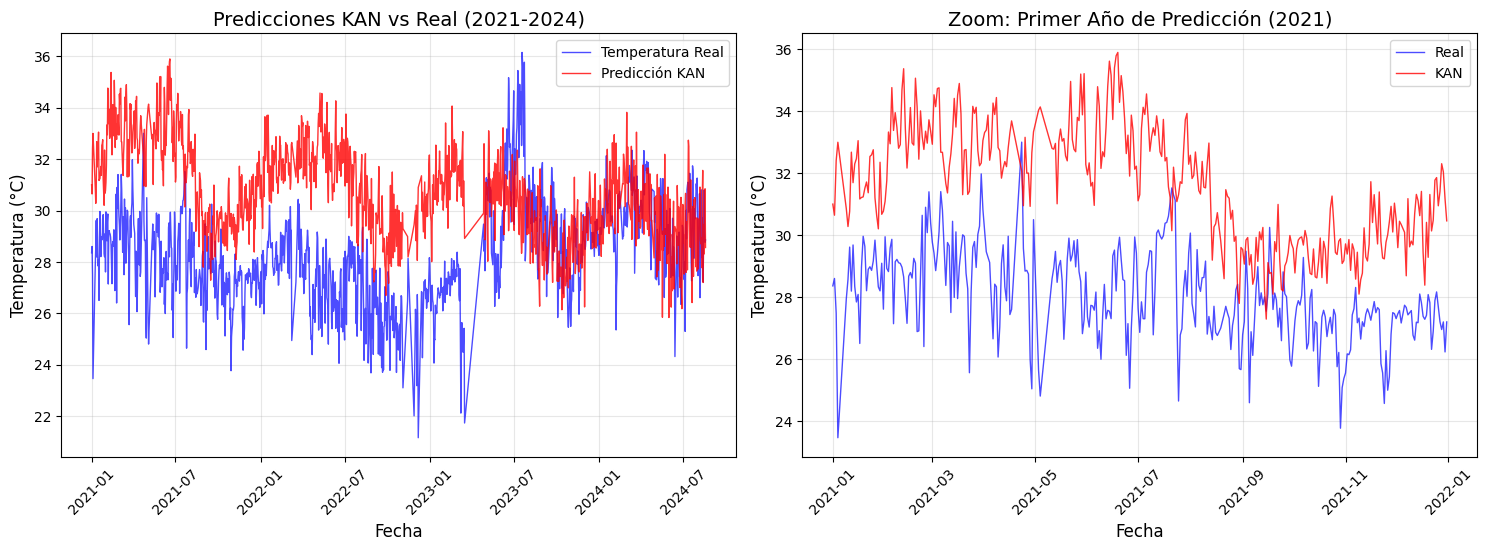

Gráficos generados correctamente


In [ ]:
# =============================================================================
# PASO 8: VISUALIZAR LOS RESULTADOS
# =============================================================================

print("\n" + "=" * 70)
print("VISUALIZANDO RESULTADOS")
print("=" * 70)

# Crear gráficos comparativos
plt.figure(figsize=(15, 10))

# Gráfico 1: Comparación completa 2021-2024
plt.subplot(2, 2, 1)
plt.plot(test_with_predictions['ds'], y_true,
         label='Temperatura Real', color='blue', alpha=0.7, linewidth=1)
plt.plot(test_with_predictions['ds'], y_pred,
         label='Predicción KAN', color='red', alpha=0.8, linewidth=1)
plt.title('Predicciones KAN vs Real (2021-2024)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Gráfico 2: Zoom en primer año (2021)
plt.subplot(2, 2, 2)
first_year = test_with_predictions[test_with_predictions['ds'] < '2022-01-01']
plt.plot(first_year['ds'], first_year['y'],
         label='Real', color='blue', alpha=0.7, linewidth=1)
plt.plot(first_year['ds'], first_year['KAN'],
         label='KAN', color='red', alpha=0.8, linewidth=1)
plt.title('Zoom: Primer Año de Predicción (2021)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Gráficos generados correctamente")

In [ ]:
# =============================================================================
# PASO 9: ANÁLISIS DETALLADO Y GUARDADO DE RESULTADOS
# =============================================================================

print("\n" + "=" * 70)
print("ANÁLISIS DETALLADO DE RESULTADOS")
print("=" * 70)

# Crear DataFrame detallado con resultados
results_df = test_with_predictions.copy()
results_df['Error'] = results_df['y'] - results_df['KAN']
results_df['Error_Absoluto'] = np.abs(results_df['Error'])
results_df['Error_Porcentual'] = (results_df['Error_Absoluto'] / results_df['y']) * 100

# Agregar columnas de año y mes para análisis
results_df['Año'] = results_df['ds'].dt.year
results_df['Mes'] = results_df['ds'].dt.month
results_df['Día_del_Año'] = results_df['ds'].dt.dayofyear

print("PRIMERAS 10 PREDICCIONES CON ERRORES:")
print(results_df[['ds', 'y', 'KAN', 'Error', 'Error_Absoluto', 'Error_Porcentual']].head(10))

# Estadísticas generales
print(f"\nESTADÍSTICAS GENERALES DEL ERROR:")
print(f"Error medio: {results_df['Error'].mean():.2f}°C")
print(f"Desviación estándar del error: {results_df['Error'].std():.2f}°C")
print(f"Máximo error positivo (subestimación): {results_df['Error'].max():.2f}°C")
print(f"Máximo error negativo (sobreestimación): {results_df['Error'].min():.2f}°C")
print(f"Porcentaje de predicciones con error < 1°C: {(results_df['Error_Absoluto'] < 1).mean()*100:.1f}%")
print(f"Porcentaje de predicciones con error < 2°C: {(results_df['Error_Absoluto'] < 2).mean()*100:.1f}%")


ANÁLISIS DETALLADO DE RESULTADOS
PRIMERAS 10 PREDICCIONES CON ERRORES:
          ds          y        KAN     Error  Error_Absoluto  Error_Porcentual
0 2021-01-01  28.360870  31.001856 -2.640986        2.640986          9.312078
1 2021-01-02  28.600000  30.643866 -2.043866        2.043866          7.146383
2 2021-01-03  27.482609  32.409904 -4.927296        4.927296         17.928778
3 2021-01-04  23.454545  33.001102 -9.546557        9.546557         40.702375
4 2021-01-09  27.941667  30.855066 -2.913400        2.913400         10.426721
5 2021-01-10  28.568182  30.278425 -1.710243        1.710243          5.986532
6 2021-01-11  29.613636  30.770634 -1.156997        1.156997          3.906975
7 2021-01-12  28.191304  32.681053 -4.489749        4.489749         15.926006
8 2021-01-13  29.682353  31.694731 -2.012378        2.012378          6.779711
9 2021-01-14  28.344444  32.302013 -3.957569        3.957569         13.962415

ESTADÍSTICAS GENERALES DEL ERROR:
Error medio: -2.44°C
Des

In [ ]:
# para ver las ultimas 10 predicciones
print(results_df[['ds', 'y', 'KAN', 'Error', 'Error_Absoluto', 'Error_Porcentual']].tail(10))

             ds          y        KAN     Error  Error_Absoluto  \
1182 2024-08-09  30.802586  28.941952  1.860634        1.860634   
1183 2024-08-10  28.704845  27.774372  0.930473        0.930473   
1184 2024-08-11  28.153252  30.500334 -2.347082        2.347082   
1185 2024-08-12  29.717473  31.562296 -1.844823        1.844823   
1186 2024-08-13  27.213286  27.197315  0.015970        0.015970   
1187 2024-08-14  30.190828  29.456001  0.734827        0.734827   
1188 2024-08-15  30.799103  28.306974  2.492129        2.492129   
1189 2024-08-16  29.184581  29.157000  0.027582        0.027582   
1190 2024-08-17  28.762719  30.845665 -2.082946        2.082946   
1191 2024-08-18  28.848522  28.559662  0.288860        0.288860   

      Error_Porcentual  
1182          6.040514  
1183          3.241519  
1184          8.336805  
1185          6.207872  
1186          0.058686  
1187          2.433942  
1188          8.091563  
1189          0.094508  
1190          7.241827  
1191        

In [ ]:
#VER PRIMERAS 10 Y ULTIMAS 10 PREDICCIONES
print(results_df[['ds', 'y', 'KAN', 'Error', 'Error_Absoluto', 'Error_Porcentual']].head(10))

          ds          y        KAN     Error  Error_Absoluto  Error_Porcentual
0 2021-01-01  28.360870  31.001856 -2.640986        2.640986          9.312078
1 2021-01-02  28.600000  30.643866 -2.043866        2.043866          7.146383
2 2021-01-03  27.482609  32.409904 -4.927296        4.927296         17.928778
3 2021-01-04  23.454545  33.001102 -9.546557        9.546557         40.702375
4 2021-01-09  27.941667  30.855066 -2.913400        2.913400         10.426721
5 2021-01-10  28.568182  30.278425 -1.710243        1.710243          5.986532
6 2021-01-11  29.613636  30.770634 -1.156997        1.156997          3.906975
7 2021-01-12  28.191304  32.681053 -4.489749        4.489749         15.926006
8 2021-01-13  29.682353  31.694731 -2.012378        2.012378          6.779711
9 2021-01-14  28.344444  32.302013 -3.957569        3.957569         13.962415


In [ ]:
#VER ULTIMAS 10 PREDICCIONES
print(results_df[['ds', 'y', 'KAN', 'Error', 'Error_Absoluto', 'Error_Porcentual']].tail(10))

             ds          y        KAN     Error  Error_Absoluto  \
1182 2024-08-09  30.802586  28.941952  1.860634        1.860634   
1183 2024-08-10  28.704845  27.774372  0.930473        0.930473   
1184 2024-08-11  28.153252  30.500334 -2.347082        2.347082   
1185 2024-08-12  29.717473  31.562296 -1.844823        1.844823   
1186 2024-08-13  27.213286  27.197315  0.015970        0.015970   
1187 2024-08-14  30.190828  29.456001  0.734827        0.734827   
1188 2024-08-15  30.799103  28.306974  2.492129        2.492129   
1189 2024-08-16  29.184581  29.157000  0.027582        0.027582   
1190 2024-08-17  28.762719  30.845665 -2.082946        2.082946   
1191 2024-08-18  28.848522  28.559662  0.288860        0.288860   

      Error_Porcentual  
1182          6.040514  
1183          3.241519  
1184          8.336805  
1185          6.207872  
1186          0.058686  
1187          2.433942  
1188          8.091563  
1189          0.094508  
1190          7.241827  
1191        